In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np

In [5]:
change_type_map = {'Demolition': 0, 'Road': 1, 'Residential': 2, 'Commercial': 3, 'Industrial': 4,
       'Mega Projects': 5}

## Read csvs

train_df = gpd.read_file('train.geojson', index_col=0)
test_df = gpd.read_file('test.geojson', index_col=0)


In [6]:
train_df["change_type"].value_counts()

Residential      148435
Commercial       100422
Demolition        31509
Road              14305
Industrial         1324
Mega Projects       151
Name: change_type, dtype: int64

In [7]:
COLORS = ['red', 'green', 'blue']
METRICS = ['std', 'mean']

CHANGE_TYPE_MAP = {'Demolition': 0, 'Road': 1, 'Residential': 2, 'Commercial': 3, 'Industrial': 4,
                   'Mega Projects': 5}
CHANGE_STATUS_MAP = {'Greenland': 1, 'Land Cleared': 2, 'Materials Introduced': 3,
                     'Prior Construction': 4, 'Excavation': 5, 'Construction Started': 6,
                     'Construction Midway': 7, 'Materials Dumped': 8, 'Construction Done': 9,
                     'Operational': 10}

GEOGRAPHY_TYPES = ['Dense Forest', 'Grass Land', 'Sparse Forest', 'Farms', 'River',
                   'Coastal', 'Lakes', 'Barren Land', 'Desert', 'Hills', 'Snow', 'N,A']
URBAN_TYPES = ['Sparse Urban', 'Rural', 'Dense Urban', 'Urban Slum', 'Industrial', 'N,A']

COLUMNS_TO_DROP = ['geography_type', 'urban_type', 'date0', 'date1', 'date2', 'date3', 'date4', 'index']
DATE_COLUMNS = ['date0', 'date1', 'date2', 'date3', 'date4']

BINARY_FEATURES = ['Dense Forest', 'Grass Land', 'Sparse Forest', 'Farms', 'River',
                   'Coastal', 'Lakes', 'Barren Land', 'Desert', 'Hills', 'Snow',
                   'Sparse Urban', 'Rural', 'Dense Urban', 'Urban Slum', 'Industrial']
CATEGORICAL_FEATURES = ['change_status_date0', 'change_status_date1', 'change_status_date2', 'change_status_date3',
                      'change_status_date4']


CHANGE_STATUS_VALUE_COLUMNS = ['change_status_value_date0', 'change_status_value_date1', 'change_status_value_date2', 'change_status_value_date3', 'change_status_value_date4']
CHANGE_STATUS_COLUMNS = ['change_status_date0', 'change_status_date1', 'change_status_date2', 'change_status_date3', 'change_status_date4']


In [8]:
copied_train_df = train_df.copy(deep=True)

In [9]:
copied_train_df['change_type'] = copied_train_df['change_type'].map(CHANGE_TYPE_MAP)

In [10]:
for i in range(5): copied_train_df[f'change_status_date{i}'] = copied_train_df[f'change_status_date{i}'].map(CHANGE_STATUS_MAP)

In [11]:
# Decidir se vamos colocar N,A como coluna ou tratar ele como NaN

In [12]:
# One-hot encoding
for geograph_type in GEOGRAPHY_TYPES:
    copied_train_df["geography_type" + geograph_type] = copied_train_df['geography_type'].apply(lambda x: 1 if geograph_type in x else 0)
for urban_type in URBAN_TYPES:
    copied_train_df["urban_type" + urban_type] = copied_train_df['urban_type'].apply(lambda x: 1 if urban_type in x else 0)


In [13]:
#copied_train_df_nan = copied_train_df[copied_train_df.isna().any(axis=1)]
#copied_train_df = copied_train_df.dropna()


In [14]:
copied_train_df[DATE_COLUMNS] = copied_train_df[DATE_COLUMNS].apply(lambda x: pd.to_datetime(x, format='%d-%m-%Y', errors='coerce'))

In [15]:
def sort_dates(row):

    # Sort columns by date
    columns_order = np.argsort(row[DATE_COLUMNS].values)
    new_row = row.copy(deep=True)

    # Update date and change_status order
    for i in range(5):
        new_row[f'date{i}'] = row[f'date{columns_order[i]}']
        new_row[f'change_status_date{i}'] = row[f'change_status_date{columns_order[i]}']

    # Update color metrics order
    for metric in METRICS:
        for color in COLORS:
            for i in range(1, 6):
                new_row[f'img_{color}_{metric}_date{i}'] = row[f'img_{color}_{metric}_date{columns_order[i-1]+1}']

    return new_row

copied_train_df = copied_train_df.apply(sort_dates, axis=1)

In [16]:
copied_train_df_save = copied_train_df.copy(deep=True)

In [17]:
copied_train_df_save[DATE_COLUMNS] = copied_train_df_save[DATE_COLUMNS].apply(np.float64)

In [18]:
copied_train_df_save.loc[copied_train_df_save['date0'] < 0, 'date0'] = np.nan
copied_train_df_save.loc[copied_train_df_save['date1'] < 0, 'date1'] = np.nan
copied_train_df_save.loc[copied_train_df_save['date2'] < 0, 'date2'] = np.nan
copied_train_df_save.loc[copied_train_df_save['date3'] < 0, 'date3'] = np.nan
copied_train_df_save.loc[copied_train_df_save['date4'] < 0, 'date4'] = np.nan

In [19]:
from shapely.geometry import Polygon, LinearRing
from scipy.spatial.distance import euclidean
import shapely



## Create new polygon features
copied_train_df_save['area'] = copied_train_df_save['geometry'].area
copied_train_df_save['length'] = copied_train_df_save['geometry'].length
copied_train_df_save['centroid_x'] = copied_train_df_save['geometry'].centroid.x
copied_train_df_save['centroid_y'] = copied_train_df_save['geometry'].centroid.y
bounds = copied_train_df_save['geometry'].bounds
copied_train_df_save['angle'] = np.arctan((bounds['maxy']-bounds['miny'])/(bounds['maxx']-bounds['minx']))
copied_train_df_save['compactness'] = 4 * np.pi * (copied_train_df_save['area'] / copied_train_df_save['length']**2) # the bigger, the closer to square

def is_paralelogram(polygon):
    it_is = True
    LIMIT = 1e-2
    # Get the outer boundary coordinates
    coords = polygon.exterior.coords[:-1]  # Exclude the closing coordinate
    
    # Check if the polygon has four sides
    num_vertices = len(coords)
    if  num_vertices != 4:  # a paralelogram should have 4 vertices
        it_is = False
        return (it_is, num_vertices, 10*LIMIT, num_vertices*4*LIMIT)

    # Calculate the lengths of the sides
    side_lengths = [euclidean(coords[i],coords[(i+1)%4]) for i in range(4)]  # Calculate the length between each pair of adjacent vertices
    
    # Check if opposite sides have equal length (index 0 and 2, index 1 and 3)
    length_dif = abs(side_lengths[0] - side_lengths[2]) + abs(side_lengths[1] - side_lengths[3])/polygon.length
    if length_dif > LIMIT:
        it_is = False
    
    return (it_is, num_vertices, length_dif, length_dif)

tmp = copied_train_df_save['geometry'].apply(is_paralelogram)
# Extract the tuple into three different columns
copied_train_df_save['paralelogram'], copied_train_df_save['num_vertices'], copied_train_df_save['length_dif1'], copied_train_df_save['length_dif2'] = zip(*tmp)
copied_train_df_save['rect_area'] = copied_train_df_save['geometry'].apply(shapely.minimum_rotated_rectangle, axis=1).area

convex_hull = copied_train_df_save['geometry'].convex_hull
copied_train_df_save['dif_convex_prop_area'] = (convex_hull.area - copied_train_df_save['area'])/ convex_hull.area
copied_train_df_save['convex'] =  copied_train_df_save['geometry'].geom_equals(convex_hull)


c:\Users\merte\anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  
c:\Users\merte\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if __name__ == '__main__':
c:\Users\merte\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  # Remove the CWD from sys.path while we load stuff.
c:\Users\merte\anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect.

In [20]:
from sklearn.cluster import KMeans

def get_centroid_lat(row):
    center = row['geometry'].centroid.xy[1][0]
    return center

def get_centroid_lon(row):
    center = row['geometry'].centroid.xy[0][0]
    return center

train_df_geo = pd.DataFrame()
train_df_geo['Lat'] = copied_train_df_save.apply(get_centroid_lat, axis=1)
train_df_geo['Lon'] = copied_train_df_save.apply(get_centroid_lon, axis=1)

kmeans = KMeans(n_clusters=4)
kmeans.fit(train_df_geo)
labels = kmeans.labels_
copied_train_df_save['geo_cluster'] = labels


## DROP
copied_train_df_save = copied_train_df_save.drop(columns=['geometry'])

In [21]:
copied_train_df_save = copied_train_df_save.drop(['geography_type', 'urban_type'], axis=1)

In [22]:
from sklearn.impute import KNNImputer

# Group the DataFrame by "change_type"
grouped = copied_train_df_save.groupby("change_type")

# Initialize KNNImputer
imputer = KNNImputer(n_neighbors=5,missing_values=np.nan)  # You can adjust the number of neighbors as needed

# Initialize an empty list to store the imputed DataFrames
imputed_dfs = []

# Iterate over each group
for change_type, group in grouped:
    # Drop the "change_type" column before imputation
    group_features = group.drop(columns=["change_type"])
    
    # Impute NaN values within the group
    imputed_values = imputer.fit_transform(group_features)
    
    # Create a DataFrame with imputed values
    imputed_df = pd.DataFrame(imputed_values, columns=group_features.columns, index=group_features.index)
    
    # Concatenate "change_type" column back to the imputed DataFrame
    imputed_df["change_type"] = change_type
    
    # Append the imputed DataFrame to the list
    imputed_dfs.append(imputed_df)

# Concatenate all imputed DataFrames into a single DataFrame
imputed_train_df = pd.concat(imputed_dfs)

# Verify if there are still NaN values after imputation
if imputed_train_df.isnull().values.any():
    print("There are still NaN values remaining after imputation.")
    print(imputed_train_df[imputed_train_df.isnull().any(axis=1)])
else:
    print("All NaN values have been imputed successfully.")

All NaN values have been imputed successfully.


In [23]:
imputed_train_df[CHANGE_STATUS_COLUMNS] = imputed_train_df[CHANGE_STATUS_COLUMNS].round().astype('int')

In [24]:
copied_of_copied_train_df = imputed_train_df.copy(deep=True)

In [25]:
## Create deltas: color and time
for metric in METRICS:
    for color in COLORS:
        for i in range(2, 6):
            delta = copied_of_copied_train_df[f'img_{color}_{metric}_date{i}'] - copied_of_copied_train_df[f'img_{color}_{metric}_date{i-1}']
            copied_of_copied_train_df[f'img_{color}_{metric}_delta{i}'] = delta
        copied_of_copied_train_df[f'img_{color}_{metric}_delta_total'] = copied_of_copied_train_df[f'img_{color}_{metric}_date5'] - copied_of_copied_train_df[f'img_{color}_{metric}_date1']
for i in range(1, 5):
    copied_of_copied_train_df[f'date_delta{i}'] = copied_of_copied_train_df[f'date{i}'] - copied_of_copied_train_df[f'date{i-1}']
copied_of_copied_train_df['date_delta_total'] = copied_of_copied_train_df[f'date4'] - copied_of_copied_train_df[f'date1']

In [26]:
## Standardizing colors mean by the proportion
for i in range(1, 6):
    color_sum = copied_of_copied_train_df[f'img_blue_mean_date{i}'] + copied_of_copied_train_df[f'img_green_mean_date{i}'] + copied_of_copied_train_df[f'img_red_mean_date{i}']
    for color in COLORS:
        copied_of_copied_train_df[f'img_{color}_mean_prop_date{i}'] = copied_of_copied_train_df[f'img_{color}_mean_date{i}']/color_sum

In [27]:
## Create img_{color}_mean_prop_rate
num_samples = copied_of_copied_train_df.shape[0]
ones = np.ones((num_samples,5,1))

for color in COLORS:
    coef = np.zeros((num_samples))
    COLOR_MEAN_COLUMNS = [f'img_{color}_mean_prop_date{i}' for i in range (1,6)]

    Y = np.array(copied_of_copied_train_df[COLOR_MEAN_COLUMNS].astype(float))
    X = np.array(copied_of_copied_train_df[DATE_COLUMNS].apply(np.float64))[:,:,np.newaxis]
    X = np.dstack((ones,X))
    nan_mask = np.isnan(Y) | np.isnan(X[:,:,1])
    X[nan_mask,:] = 0
    Y[nan_mask] = 0

    eye = np.eye(2)*0.0001
    for i in range(num_samples):
        x = X[i].reshape((5,2))
        y = Y[i].reshape((5))
        coef[i] = (np.linalg.inv(eye+x.T@x)@x.T@y)[1]

    copied_of_copied_train_df[f'img_{color}_mean_prop_rate'] = coef



In [28]:
## Create img_{color}_std_rate
for color in COLORS:
    coef = np.zeros((num_samples))
    COLOR_STD_COLUMNS = [f'img_{color}_std_date{i}' for i in range (1,6)]

    Y = np.array(copied_of_copied_train_df[COLOR_STD_COLUMNS].astype(float))
    X = np.array(copied_of_copied_train_df[DATE_COLUMNS].apply(np.float64))[:,:,np.newaxis]
    X = np.dstack((ones,X))
    nan_mask = np.isnan(Y) | np.isnan(X[:,:,1])
    X[nan_mask,:] = 0
    Y[nan_mask] = 0

    eye = np.eye(2)*0.0001
    for i in range(num_samples):
        x = X[i].reshape((5,2))
        y = Y[i].reshape((5))
        coef[i] = (np.linalg.inv(eye+x.T@x)@x.T@y)[1]

    copied_of_copied_train_df[f'img_{color}_std_rate'] = coef

In [29]:
# delta_dates = ['date_delta1','date_delta2', 'date_delta3', 'date_delta4', 'date_delta_total']
# for delta_date in delta_dates: copied_of_copied_train_df[delta_date] = copied_of_copied_train_df[delta_date].dt.days

In [30]:
ready_to_train_df = copied_of_copied_train_df.copy(deep=True)

In [31]:
## Create civilization_rate
num_samples = ready_to_train_df.shape[0]
coef = np.zeros((num_samples))
time_ctt = 1e9*60*90*24
ones = np.ones((num_samples,5,1))

Y = np.array(ready_to_train_df[CHANGE_STATUS_COLUMNS].astype(float))
Y_nan_mask = np.isnan(Y)
X = np.array(ready_to_train_df[DATE_COLUMNS].apply(np.float64))[:,:,np.newaxis]/time_ctt
X = np.dstack((ones,X))
X[Y_nan_mask,:] = 0
Y[Y_nan_mask] = 0

eye = np.eye(2)*0.0001
for i in range(num_samples):
    x = X[i].reshape((5,2))
    y = Y[i].reshape((5))
    coef[i] = (np.linalg.inv(eye+x.T@x)@x.T@y)[1]
    #print(y, train_df["change_type"].iloc[i])
ready_to_train_df["civilizating_rate"] = coef

In [32]:
list(ready_to_train_df.columns)

['img_red_mean_date1',
 'img_green_mean_date1',
 'img_blue_mean_date1',
 'img_red_std_date1',
 'img_green_std_date1',
 'img_blue_std_date1',
 'img_red_mean_date2',
 'img_green_mean_date2',
 'img_blue_mean_date2',
 'img_red_std_date2',
 'img_green_std_date2',
 'img_blue_std_date2',
 'img_red_mean_date3',
 'img_green_mean_date3',
 'img_blue_mean_date3',
 'img_red_std_date3',
 'img_green_std_date3',
 'img_blue_std_date3',
 'img_red_mean_date4',
 'img_green_mean_date4',
 'img_blue_mean_date4',
 'img_red_std_date4',
 'img_green_std_date4',
 'img_blue_std_date4',
 'img_red_mean_date5',
 'img_green_mean_date5',
 'img_blue_mean_date5',
 'img_red_std_date5',
 'img_green_std_date5',
 'img_blue_std_date5',
 'date0',
 'change_status_date0',
 'date1',
 'change_status_date1',
 'date2',
 'change_status_date2',
 'date3',
 'change_status_date3',
 'date4',
 'change_status_date4',
 'index',
 'geography_typeDense Forest',
 'geography_typeGrass Land',
 'geography_typeSparse Forest',
 'geography_typeFarms',

In [121]:
useful_features = ['civilizating_rate', 'centroid_x',
 'centroid_y', 'img_blue_std_date5',
'img_green_std_date5',
'change_status_value_date0',
'change_status_value_date2',
'date0',
'change_status_value_date4',
'img_red_std_delta_total',
'change_status_value_date3',
'img_green_std_delta_total',
'change_status_value_date1',
'img_blue_std_delta_total',
'area_to_length_ratio', 'geography_typeDense Forest',
 'geography_typeGrass Land',
 'geography_typeSparse Forest',
 'geography_typeFarms',
 'geography_typeRiver',
 'geography_typeCoastal',
 'geography_typeLakes',
 'geography_typeBarren Land',
 'geography_typeDesert',
 'geography_typeHills',
 'geography_typeSnow',
 'urban_typeSparse Urban',
 'urban_typeRural',
 'urban_typeDense Urban',
 'urban_typeUrban Slum',
 'urban_typeIndustrial']


a = ['geography_typeDense Forest',
 'geography_typeGrass Land',
 'geography_typeSparse Forest',
 'geography_typeFarms',
 'geography_typeRiver',
 'geography_typeCoastal',
 'geography_typeLakes',
 'geography_typeBarren Land',
 'geography_typeDesert',
 'geography_typeHills',
 'geography_typeSnow',
 'urban_typeSparse Urban',
 'urban_typeRural',
 'urban_typeDense Urban',
 'urban_typeUrban Slum',
 'urban_typeIndustrial']


useful_features = [ 'geography_typeFarms', 'geography_typeRiver', 'img_red_mean_date2', 'centroid_x',
 'geography_typeCoastal', 'geography_typeLakes', 'urban_typeUrban Slum', 'urban_typeIndustrial', 'img_blue_mean_date3',
 'civilizating_rate', 'centroid_y', 'img_green_mean_date5', 'img_green_mean_date3', 'img_red_mean_date5', 'date0', 'date3',
 'area', 'date_delta_total', 'change_status_date4', 'change_status_date0', 'change_status_date1', 'date1', 'compactness'
]


useful_features = [ 
 'area', 'compactness', 'civilizating_rate', 'geography_typeLakes', 'geography_typeFarms', 'centroid_y', 'urban_typeIndustrial',
 'urban_typeUrban Slum', 'img_red_mean_prop_rate', 'img_green_mean_prop_rate', 'img_blue_mean_prop_rate', 'img_red_std_rate', 'centroid_x'
]

useful_features = [ 'geography_typeFarms', 'centroid_x',
 'geography_typeCoastal', 'geography_typeLakes', 'urban_typeUrban Slum', 'urban_typeIndustrial',
 'civilizating_rate', 'centroid_y', 'date0', 'img_red_mean_prop_rate', 'img_green_mean_prop_rate', 'img_blue_mean_prop_rate',
 'area', 'date_delta_total', 'change_status_date4', 'date1', 'compactness', 'img_red_std_rate', 'paralelogram',
 'num_vertices', 'angle',
 'length_dif1',
 'length_dif2', 'geo_cluster', 'rect_area', 'convex', 'dif_convex_prop_area', 
]


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
#plt.figure(figsize=(5, 10))
#sns.boxplot(data= ready_to_train_df, x= 'change_type', y = 'change_status_date4')

In [120]:
ready_to_train_df["change_type"].value_counts()

2    148435
3    100422
0     31509
1     14305
4      1324
5       151
Name: change_type, dtype: int64

[]

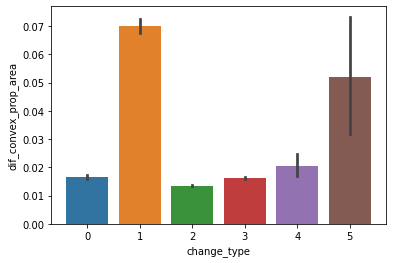

In [75]:

i = 20
plt.figure()
sns.barplot(data= ready_to_train_df, x= 'change_type', y ="dif_convex_prop_area")
plt.plot()


In [87]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

y = ready_to_train_df["change_type"]

X = ready_to_train_df[useful_features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=60, shuffle=True)


train_concated = pd.concat([X_train, y_train], axis=1)

counts = list(train_concated["change_type"].value_counts())

df_class_0 = train_concated[train_concated['change_type'] == 0]
df_class_1 = train_concated[train_concated['change_type'] == 1]
df_class_2 = train_concated[train_concated['change_type'] == 2]
df_class_3 = train_concated[train_concated['change_type'] == 3]
df_class_4 = train_concated[train_concated['change_type'] == 4]
df_class_5 = train_concated[train_concated['change_type'] == 5]

df_class_1_under = df_class_1.sample(counts[2], replace=True)
df_class_4_under = df_class_4.sample(counts[2], replace=True)
df_class_5_under = df_class_5.sample(counts[2], replace=True)

df_test_under = pd.concat([df_class_0, df_class_1_under, df_class_3, df_class_4_under, df_class_5_under, df_class_2], axis=0)


clf = RandomForestClassifier(n_estimators=200, random_state=50, max_features=int(len(useful_features)*0.6),
                              max_depth=300, min_samples_leaf=1, class_weight={0: 1, 1: 1, 2:1, 3:1, 4:10, 5:100})
clf.fit(df_test_under[useful_features], df_test_under["change_type"])


'\n\ntrain_concated = pd.concat([X_train, y_train], axis=1)\n\ncounts = list(train_concated["change_type"].value_counts())\n\ndf_class_0 = train_concated[train_concated[\'change_type\'] == 0]\ndf_class_1 = train_concated[train_concated[\'change_type\'] == 1]\ndf_class_2 = train_concated[train_concated[\'change_type\'] == 2]\ndf_class_3 = train_concated[train_concated[\'change_type\'] == 3]\ndf_class_4 = train_concated[train_concated[\'change_type\'] == 4]\ndf_class_5 = train_concated[train_concated[\'change_type\'] == 5]\n\ndf_class_1_under = df_class_1.sample(counts[2], replace=True)\ndf_class_4_under = df_class_4.sample(counts[2], replace=True)\ndf_class_5_under = df_class_5.sample(counts[2], replace=True)\n\ndf_test_under = pd.concat([df_class_0, df_class_1_under, df_class_3, df_class_4_under, df_class_5_under, df_class_2], axis=0)\n\n\nclf = RandomForestClassifier(n_estimators=200, random_state=50, max_features=int(len(useful_features)*0.6),\n                              max_depth

In [122]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

y = ready_to_train_df["change_type"]

X = ready_to_train_df[useful_features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=60, shuffle=True)



df_test_under = pd.concat([df_class_0, df_class_1_under, df_class_3, df_class_4_under, df_class_5_under, df_class_2], axis=0)


clf = RandomForestClassifier(n_estimators=100, random_state=50)
clf.fit(X_train, y_train)


RandomForestClassifier(random_state=50)

In [123]:
from sklearn.metrics import f1_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_predicted_train = clf.predict(X_train[useful_features])

print(precision_score(y_train, y_predicted_train, average="micro"))
print(f1_score(y_train, y_predicted_train, average="macro"))


0.9998611793750071
0.9989343169070946


In [124]:

y_predicted = clf.predict(X_test[useful_features])

print(precision_score(y_test, y_predicted, average="micro"))
print(f1_score(y_test, y_predicted, average="macro"))

0.7576228262704711
0.510243189756829


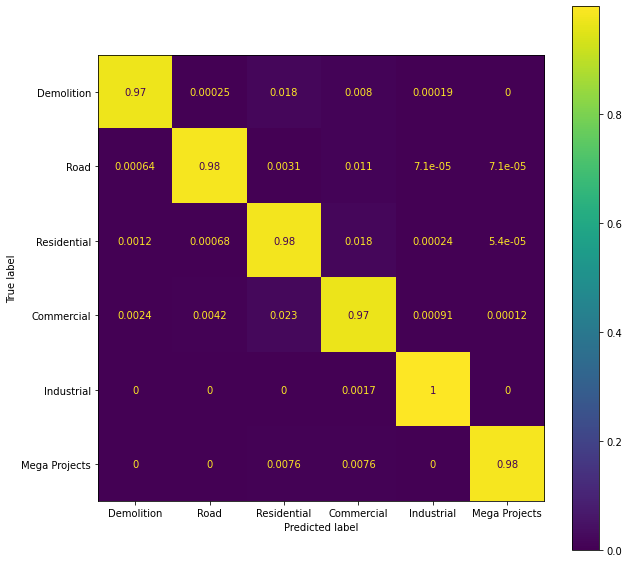

In [130]:
fig, ax = plt.subplots(figsize=(10,10))
cmd = ConfusionMatrixDisplay(confusion_matrix(clf.predict(X), y, normalize='true'), display_labels=list(CHANGE_TYPE_MAP.keys()))
cmd.plot(ax=ax)
plt.show()

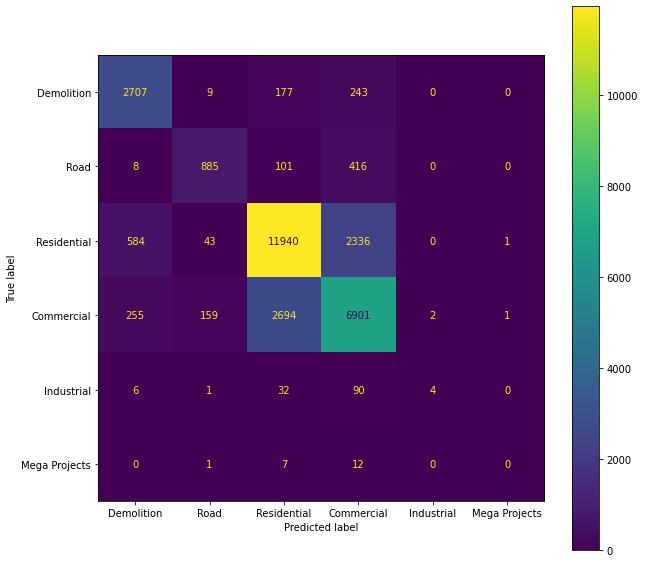

In [125]:
fig, ax = plt.subplots(figsize=(10,10))
cmd = ConfusionMatrixDisplay(confusion_matrix(y_test, y_predicted), display_labels=list(CHANGE_TYPE_MAP.keys()))
cmd.plot(ax=ax)
plt.show()

# New Approach

In [131]:
ready_to_train_df["industrial_and_megaprojects"] = (ready_to_train_df["change_type"] > 3).replace({True: 1, False: 0})
indus_mega_ready_to_train_df = ready_to_train_df.loc[ready_to_train_df['industrial_and_megaprojects'] == 1]

others_ready_to_train_df = ready_to_train_df.loc[ready_to_train_df['industrial_and_megaprojects'] == 0]

In [153]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=142)
X = ready_to_train_df.loc[:, ready_to_train_df.columns != "industrial_and_megaprojects"]
y = ready_to_train_df["industrial_and_megaprojects"]
X_resampled, y_resampled = rus.fit_resample(X, y)

In [31]:
from imblearn.under_sampling import ClusterCentroids
cc = ClusterCentroids(random_state=142)
X = ready_to_train_df.loc[:, ready_to_train_df.columns != "industrial_and_megaprojects"]
y = ready_to_train_df["industrial_and_megaprojects"]
X_resampled, y_resampled = cc.fit_resample(X, y)


c:\Users\merte\anaconda3\lib\site-packages\imblearn\under_sampling\_prototype_generation\_cluster_centroids.py:178: ConvergenceWarning: Number of distinct clusters (1287) found smaller than n_clusters (1475). Possibly due to duplicate points in X.
  self.estimator_.fit(_safe_indexing(X, target_class_indices))


In [32]:
train_concated = pd.concat([X_resampled, y_resampled], axis=1)
train_concated.to_csv("a.csv")

In [44]:
b = ['change_status_date0',
 'change_status_date1',
 'change_status_date2',
 'change_status_date3',
 'change_status_date4','geography_typeDense Forest',
 'geography_typeGrass Land',
 'geography_typeSparse Forest',
 'geography_typeFarms',
 'geography_typeRiver',
 'geography_typeCoastal',
 'geography_typeLakes',
 'geography_typeBarren Land',
 'geography_typeDesert',
 'geography_typeHills',
 'geography_typeSnow',
 'geography_typeN,A',
 'urban_typeSparse Urban',
 'urban_typeRural',
 'urban_typeDense Urban',
 'urban_typeUrban Slum',
 'urban_typeIndustrial',
 'urban_typeN,A',
]
train_concated[b] = train_concated[b].round().astype(int)

In [132]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# X = train_concated[useful_features]
# y = train_concated["industrial_and_megaprojects"]
# df_first_tree = pd.concat([others_ready_to_train_df.sample(indus_mega_ready_to_train_df.shape[0]*4), indus_mega_ready_to_train_df], axis=0)


y = ready_to_train_df["industrial_and_megaprojects"]

X = ready_to_train_df[useful_features]

# get_new_features

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)

#train_concated = pd.concat([X_train, y_train], axis=1)

#counts = list(train_concated["industrial_and_megaprojects"].value_counts())

#df_class_0 = train_concated[train_concated['industrial_and_megaprojects'] == 0]
#df_class_1 = train_concated[train_concated['industrial_and_megaprojects'] == 1]


#df_class_1_under = df_class_1.sample(counts[0], replace=True)

#df_test_under = pd.concat([df_class_0, df_class_1_under], axis=0)

#X_train = df_test_under[useful_features]
#y_train = df_test_under["industrial_and_megaprojects"]

clf_first_tree = RandomForestClassifier(n_estimators=50, random_state=42, min_samples_leaf=1)
clf_first_tree.fit(X_train, y_train)


RandomForestClassifier(n_estimators=50, random_state=42)

In [133]:
from sklearn.metrics import f1_score, precision_score

y_predicted_train = clf_first_tree.predict(X_train)

print(precision_score(y_train, y_predicted_train, average="micro"))
print(f1_score(y_train, y_predicted_train, average="macro"))


0.9999062022804102
0.9953000388267921


In [134]:
from sklearn.metrics import f1_score, precision_score

y_predicted_real = clf_first_tree.predict(ready_to_train_df[useful_features])

print(precision_score(ready_to_train_df["industrial_and_megaprojects"], y_predicted_real, average="micro"))
print(f1_score(ready_to_train_df["industrial_and_megaprojects"], y_predicted_real, average="macro"))


0.9995002465000371
0.9734835971489155


In [135]:
from sklearn.metrics import f1_score, precision_score

y_predicted_test = clf_first_tree.predict(X_test)

print(precision_score(y_test, y_predicted_test, average="micro"))
print(f1_score(y_test, y_predicted_test, average="macro"))


0.9958466993077832
0.5294937244000848


In [136]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

y = indus_mega_ready_to_train_df["change_type"]

X = indus_mega_ready_to_train_df[useful_features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)


clf_second_tree = RandomForestClassifier(n_estimators=50, random_state=42, min_samples_leaf=1)
clf_second_tree.fit(X_train, y_train)


RandomForestClassifier(n_estimators=50, random_state=42)

In [137]:
from sklearn.metrics import f1_score, precision_score

y_predicted_train = clf_second_tree.predict(X_train)

print(precision_score(y_train, y_predicted_train, average="micro"))
print(f1_score(y_train, y_predicted_train, average="macro"))


1.0
1.0


In [138]:
from sklearn.metrics import f1_score, precision_score

y_predicted_test = clf_second_tree.predict(X_test)

print(precision_score(y_test, y_predicted_test, average="micro"))
print(f1_score(y_test, y_predicted_test, average="macro"))


0.9527027027027027
0.78157284419144


In [139]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

y = others_ready_to_train_df["change_type"]

X = others_ready_to_train_df[useful_features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, shuffle=True)


clf_third_tree = RandomForestClassifier(n_estimators=100, random_state=42, min_samples_leaf=1)
clf_third_tree.fit(X_train, y_train)


In [ ]:
from sklearn.metrics import f1_score, precision_score

y_predicted_train = clf_third_tree.predict(X_train)

print(precision_score(y_train, y_predicted_train, average="micro"))
print(f1_score(y_train, y_predicted_train, average="macro"))


0.9999736051251306
0.9999807454002991


In [ ]:
from sklearn.metrics import f1_score, precision_score

y_predicted_test = clf_third_tree.predict(X_test)

print(precision_score(y_test, y_predicted_test, average="micro"))
print(f1_score(y_test, y_predicted_test, average="macro"))


0.7601805348174291
0.7504008922584414


# To submit

In [35]:
ready_to_train_df["change_type"].value_counts()

2    148435
3    100422
0     31509
1     14305
4      1324
5       151
Name: change_type, dtype: int64

In [84]:
useful_features = [ 'centroid_x',
 'civilizating_rate', 'centroid_y', 'date0', 'img_red_mean_prop_rate', 'img_green_mean_prop_rate', 'img_blue_mean_prop_rate',
 'area', 'date_delta_total', 'change_status_date4', 'date1', 'compactness', 'img_red_std_rate', 'img_blue_std_rate', 'img_green_std_rate',
 'paralelogram', 'change_status_date0', 'change_status_date1',
 'num_vertices',
 'length_dif1',
 'length_dif2',
 'geography_typeDense Forest',
 'geography_typeGrass Land',
 'geography_typeSparse Forest',
 'geography_typeFarms',
 'geography_typeRiver',
 'geography_typeCoastal',
 'geography_typeLakes',
 'geography_typeBarren Land',
 'geography_typeDesert',
 'geography_typeHills',
 'geography_typeSnow',
 'urban_typeSparse Urban',
 'urban_typeRural',
 'urban_typeDense Urban',
 'urban_typeUrban Slum',
 'urban_typeIndustrial'
]

useful_features = [ 'geography_typeFarms', 'centroid_x',
 'geography_typeCoastal', 'geography_typeLakes', 'urban_typeUrban Slum', 'urban_typeIndustrial',
 'civilizating_rate', 'centroid_y', 'date0', 'img_red_mean_prop_rate', 'img_green_mean_prop_rate', 'img_blue_mean_prop_rate',
 'area', 'date_delta_total', 'change_status_date4', 'date1', 'compactness', 'img_red_std_rate', 'paralelogram',
 'num_vertices',
 'length_dif1',
 'length_dif2'
]

useful_features = [ 'geography_typeFarms', 'centroid_x',
 'geography_typeCoastal', 'geography_typeLakes', 'urban_typeUrban Slum', 'urban_typeIndustrial',
 'civilizating_rate', 'centroid_y', 'date0', 'img_red_mean_prop_rate', 'img_green_mean_prop_rate', 'img_blue_mean_prop_rate',
 'area', 'date_delta_total', 'change_status_date4', 'date1', 'compactness', 'img_red_std_rate', 'paralelogram',
 'num_vertices', 'angle',
 'length_dif1',
 'length_dif2', 'geo_cluster', 'rect_area', 'convex', 'dif_convex_prop_area', 
]




In [81]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


counts = list(ready_to_train_df["change_type"].value_counts())

df_class_0 = ready_to_train_df[ready_to_train_df['change_type'] == 0]
df_class_1 = ready_to_train_df[ready_to_train_df['change_type'] == 1]
df_class_2 = ready_to_train_df[ready_to_train_df['change_type'] == 2]
df_class_3 = ready_to_train_df[ready_to_train_df['change_type'] == 3]
df_class_4 = ready_to_train_df[ready_to_train_df['change_type'] == 4]
df_class_5 = ready_to_train_df[ready_to_train_df['change_type'] == 5]

df_class_1_under = df_class_1.sample(counts[1], replace=True)
df_class_0_under = df_class_0.sample(counts[1], replace=True)
df_class_4_under = df_class_4.sample(counts[1], replace=True)
df_class_5_under = df_class_5.sample(counts[1], replace=True)

df_test_under = pd.concat([df_class_0_under, df_class_1_under, df_class_3, df_class_4_under, df_class_5_under, df_class_2], axis=0)


clf = RandomForestClassifier(n_estimators=80, random_state=60)
clf.fit(ready_to_train_df[useful_features], ready_to_train_df["change_type"])


RandomForestClassifier(n_estimators=80, random_state=60)

In [35]:
copied_test_df = test_df.copy(deep=True)

In [36]:
for i in range(5): copied_test_df[f'change_status_date{i}'] = copied_test_df[f'change_status_date{i}'].map(CHANGE_STATUS_MAP)

In [37]:
# Decidir se vamos colocar N,A como coluna ou tratar ele como NaN

In [38]:
# One-hot encoding
for geograph_type in GEOGRAPHY_TYPES:
    copied_test_df["geography_type" + geograph_type] = copied_test_df['geography_type'].apply(lambda x: 1 if geograph_type in x else 0)
for urban_type in URBAN_TYPES:
    copied_test_df["urban_type" + urban_type] = copied_test_df['urban_type'].apply(lambda x: 1 if urban_type in x else 0)


In [39]:
copied_test_df[DATE_COLUMNS] = copied_test_df[DATE_COLUMNS].apply(lambda x: pd.to_datetime(x, format='%d-%m-%Y', errors='coerce'))

In [40]:
def sort_dates(row):

    # Sort columns by date
    columns_order = np.argsort(row[DATE_COLUMNS].values)
    new_row = row.copy(deep=True)

    # Update date and change_status order
    for i in range(5):
        new_row[f'date{i}'] = row[f'date{columns_order[i]}']
        new_row[f'change_status_date{i}'] = row[f'change_status_date{columns_order[i]}']

    # Update color metrics order
    for metric in METRICS:
        for color in COLORS:
            for i in range(1, 6):
                new_row[f'img_{color}_{metric}_date{i}'] = row[f'img_{color}_{metric}_date{columns_order[i-1]+1}']

    return new_row

copied_test_df = copied_test_df.apply(sort_dates, axis=1)

In [41]:
copied_test_df_save = copied_test_df.copy(deep=True)

In [42]:
copied_test_df_save[DATE_COLUMNS] = copied_test_df_save[DATE_COLUMNS].apply(np.float64)

In [43]:
copied_test_df_save.loc[copied_test_df_save['date0'] < 0, 'date0'] = np.nan
copied_test_df_save.loc[copied_test_df_save['date1'] < 0, 'date1'] = np.nan
copied_test_df_save.loc[copied_test_df_save['date2'] < 0, 'date2'] = np.nan
copied_test_df_save.loc[copied_test_df_save['date3'] < 0, 'date3'] = np.nan
copied_test_df_save.loc[copied_test_df_save['date4'] < 0, 'date4'] = np.nan

In [44]:
## Create new polygon features
copied_test_df_save['area'] = copied_test_df_save['geometry'].area
copied_test_df_save['length'] = copied_test_df_save['geometry'].length
copied_test_df_save['centroid_x'] = copied_test_df_save['geometry'].centroid.x
copied_test_df_save['centroid_y'] = copied_test_df_save['geometry'].centroid.y
bounds = copied_test_df_save['geometry'].bounds
copied_test_df_save['angle'] = np.arctan((bounds['maxy']-bounds['miny'])/(bounds['maxx']-bounds['minx']))
copied_test_df_save['compactness'] = 4 * np.pi * (copied_test_df_save['area'] / copied_test_df_save['length']**2) # the bigger, the closer to square
def is_paralelogram(polygon):
    it_is = True
    LIMIT = 1e-2
    # Get the outer boundary coordinates
    coords = polygon.exterior.coords[:-1]  # Exclude the closing coordinate
    
    # Check if the polygon has four sides
    num_vertices = len(coords)
    if  num_vertices != 4:  # a paralelogram should have 4 vertices
        it_is = False
        return (it_is, num_vertices, 10*LIMIT, num_vertices*4*LIMIT)

    # Calculate the lengths of the sides
    side_lengths = [euclidean(coords[i],coords[(i+1)%4]) for i in range(4)]  # Calculate the length between each pair of adjacent vertices
    
    # Check if opposite sides have equal length (index 0 and 2, index 1 and 3)
    length_dif = abs(side_lengths[0] - side_lengths[2]) + abs(side_lengths[1] - side_lengths[3])/polygon.length
    if length_dif > LIMIT:
        it_is = False
    
    return (it_is, num_vertices, length_dif, length_dif)

tmp = copied_test_df_save['geometry'].apply(is_paralelogram)
# Extract the tuple into three different columns
copied_test_df_save['paralelogram'], copied_test_df_save['num_vertices'], copied_test_df_save['length_dif1'], copied_test_df_save['length_dif2'] = zip(*tmp)
copied_test_df_save['rect_area'] = copied_test_df_save['geometry'].apply(shapely.minimum_rotated_rectangle, axis=1).area

convex_hull = copied_test_df_save['geometry'].convex_hull
copied_test_df_save['dif_convex_prop_area'] = (convex_hull.area - copied_test_df_save['area'])/ convex_hull.area
copied_test_df_save['convex'] =  copied_test_df_save['geometry'].geom_equals(convex_hull)

c:\Users\merte\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  
c:\Users\merte\anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  This is separate from the ipykernel package so we can avoid doing imports until
c:\Users\merte\anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  after removing the cwd from sys.path.
c:\Users\merte\anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Geometry is in a geographic CRS. Results 

In [45]:
from sklearn.cluster import KMeans

def get_centroid_lat(row):
    center = row['geometry'].centroid.xy[1][0]
    return center

def get_centroid_lon(row):
    center = row['geometry'].centroid.xy[0][0]
    return center

test_df_geo = pd.DataFrame()
test_df_geo['Lat'] = copied_test_df_save.apply(get_centroid_lat, axis=1)
test_df_geo['Lon'] = copied_test_df_save.apply(get_centroid_lon, axis=1)

labels = kmeans.predict(test_df_geo)
copied_test_df_save['geo_cluster'] = labels


## DROP
copied_test_df_save = copied_test_df_save.drop(columns=['geometry'])

In [46]:
copied_test_df_save = copied_test_df_save.drop(['geography_type', 'urban_type'], axis=1)

In [47]:
from sklearn.impute import KNNImputer

# Group the DataFrame by "change_type"

# Initialize KNNImputer
imputer = KNNImputer(n_neighbors=7,missing_values=np.nan)  # You can adjust the number of neighbors as needed

# Initialize an empty list to store the imputed DataFrames

# Iterate over each group
    # Drop the "change_type" column before imputation
    
    # Impute NaN values within the group
imputed_values = imputer.fit_transform(copied_test_df_save)
    
    # Create a DataFrame with imputed values
imputed_test_df = pd.DataFrame(imputed_values, columns=copied_test_df_save.columns, index=copied_test_df_save.index)
    
    # Concatenate "change_type" column back to the imputed DataFrame
    


# Verify if there are still NaN values after imputation
if imputed_test_df.isnull().values.any():
    print("There are still NaN values remaining after imputation.")
    print(imputed_test_df[imputed_test_df.isnull().any(axis=1)])
else:
    print("All NaN values have been imputed successfully.")

All NaN values have been imputed successfully.


In [48]:
imputed_test_df[CHANGE_STATUS_COLUMNS] = imputed_test_df[CHANGE_STATUS_COLUMNS].round().astype('int')

In [49]:
copied_of_copied_test_df = imputed_test_df.copy(deep=True)

In [50]:
## Create deltas: color and time
for metric in METRICS:
    for color in COLORS:
        for i in range(2, 6):
            delta = copied_of_copied_test_df[f'img_{color}_{metric}_date{i}'] - copied_of_copied_test_df[f'img_{color}_{metric}_date{i-1}']
            copied_of_copied_test_df[f'img_{color}_{metric}_delta{i}'] = delta
        copied_of_copied_test_df[f'img_{color}_{metric}_delta_total'] = copied_of_copied_test_df[f'img_{color}_{metric}_date5'] - copied_of_copied_test_df[f'img_{color}_{metric}_date1']
for i in range(1, 5):
    copied_of_copied_test_df[f'date_delta{i}'] = copied_of_copied_test_df[f'date{i}'] - copied_of_copied_test_df[f'date{i-1}']
copied_of_copied_test_df['date_delta_total'] = copied_of_copied_test_df[f'date4'] - copied_of_copied_test_df[f'date1']

In [51]:
## Standardizing colors mean by the proportion
for i in range(1, 6):
    color_sum = copied_of_copied_test_df[f'img_blue_mean_date{i}'] + copied_of_copied_test_df[f'img_green_mean_date{i}'] + copied_of_copied_test_df[f'img_red_mean_date{i}']
    for color in COLORS:
        copied_of_copied_test_df[f'img_{color}_mean_prop_date{i}'] = copied_of_copied_test_df[f'img_{color}_mean_date{i}']/color_sum

In [52]:
## Create img_{color}_mean_prop_rate
num_samples = copied_of_copied_test_df.shape[0]
ones = np.ones((num_samples,5,1))

for color in COLORS:
    coef = np.zeros((num_samples))
    COLOR_MEAN_COLUMNS = [f'img_{color}_mean_prop_date{i}' for i in range (1,6)]

    Y = np.array(copied_of_copied_test_df[COLOR_MEAN_COLUMNS].astype(float))
    X = np.array(copied_of_copied_test_df[DATE_COLUMNS].apply(np.float64))[:,:,np.newaxis]
    X = np.dstack((ones,X))
    nan_mask = np.isnan(Y) | np.isnan(X[:,:,1])
    X[nan_mask,:] = 0
    Y[nan_mask] = 0

    eye = np.eye(2)*0.0001
    for i in range(num_samples):
        x = X[i].reshape((5,2))
        y = Y[i].reshape((5))
        coef[i] = (np.linalg.inv(eye+x.T@x)@x.T@y)[1]

    copied_of_copied_test_df[f'img_{color}_mean_prop_rate'] = coef



In [53]:
## Create img_{color}_std_rate
for color in COLORS:
    coef = np.zeros((num_samples))
    COLOR_STD_COLUMNS = [f'img_{color}_std_date{i}' for i in range (1,6)]

    Y = np.array(copied_of_copied_test_df[COLOR_STD_COLUMNS].astype(float))
    X = np.array(copied_of_copied_test_df[DATE_COLUMNS].apply(np.float64))[:,:,np.newaxis]
    X = np.dstack((ones,X))
    nan_mask = np.isnan(Y) | np.isnan(X[:,:,1])
    X[nan_mask,:] = 0
    Y[nan_mask] = 0

    eye = np.eye(2)*0.0001
    for i in range(num_samples):
        x = X[i].reshape((5,2))
        y = Y[i].reshape((5))
        coef[i] = (np.linalg.inv(eye+x.T@x)@x.T@y)[1]

    copied_of_copied_test_df[f'img_{color}_std_rate'] = coef

In [54]:
# delta_dates = ['date_delta1','date_delta2', 'date_delta3', 'date_delta4', 'date_delta_total']
# for delta_date in delta_dates: copied_of_copied_train_df[delta_date] = copied_of_copied_train_df[delta_date].dt.days

In [55]:
ready_to_test_df = copied_of_copied_test_df.copy(deep=True)

In [56]:
## Create civilization_rate
num_samples = ready_to_test_df.shape[0]
coef = np.zeros((num_samples))
time_ctt = 1e9*60*90*24
ones = np.ones((num_samples,5,1))

Y = np.array(ready_to_test_df[CHANGE_STATUS_COLUMNS].astype(float))
Y_nan_mask = np.isnan(Y)
X = np.array(ready_to_test_df[DATE_COLUMNS].apply(np.float64))[:,:,np.newaxis]/time_ctt
X = np.dstack((ones,X))
X[Y_nan_mask,:] = 0
Y[Y_nan_mask] = 0

eye = np.eye(2)*0.0001
for i in range(num_samples):
    x = X[i].reshape((5,2))
    y = Y[i].reshape((5))
    coef[i] = (np.linalg.inv(eye+x.T@x)@x.T@y)[1]
    #print(y, train_df["change_type"].iloc[i])
ready_to_test_df["civilizating_rate"] = coef

In [82]:
y_test_predicted = clf.predict(ready_to_test_df[useful_features])


In [83]:
pd.DataFrame(y_test_predicted, columns=["change_type"]).to_csv("to_submit.csv")

# Other Approach submit

In [86]:
ready_to_train_df["industrial_and_megaprojects"] = (ready_to_train_df["change_type"] > 3).replace({True: 1, False: 0})
indus_mega_ready_to_train_df = ready_to_train_df.loc[ready_to_train_df['industrial_and_megaprojects'] == 1]

others_ready_to_train_df = ready_to_train_df.loc[ready_to_train_df['industrial_and_megaprojects'] == 0]

In [113]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# df_first_tree = pd.concat([X_resampled, y_resampled], axis=1)
# df_first_tree = pd.concat([others_ready_to_train_df.sample(indus_mega_ready_to_train_df.shape[0]*4), indus_mega_ready_to_train_df], axis=0)


#y = ready_to_train_df["industrial_and_megaprojects"]

#X = ready_to_train_df[useful_features]

#train_concated = pd.concat([X, y], axis=1)

#counts = list(train_concated["industrial_and_megaprojects"].value_counts())

#df_class_0 = train_concated[train_concated['industrial_and_megaprojects'] == 0]
#df_class_1 = train_concated[train_concated['industrial_and_megaprojects'] == 1]


#df_class_1_under = df_class_1.sample(counts[0], replace=True)

#df_test_under = pd.concat([df_class_0, df_class_1_under], axis=0)

X = ready_to_train_df[useful_features]
y = ready_to_train_df["industrial_and_megaprojects"]

clf_first_tree = RandomForestClassifier(n_estimators=50, random_state=42, min_samples_leaf=1)
clf_first_tree.fit(X, y)


RandomForestClassifier(n_estimators=50, random_state=42)

In [114]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

y = indus_mega_ready_to_train_df["change_type"]

X = indus_mega_ready_to_train_df[useful_features]



clf_second_tree = RandomForestClassifier(n_estimators=40, random_state=42)
clf_second_tree.fit(X, y)


RandomForestClassifier(n_estimators=40, random_state=42)

In [115]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

y = others_ready_to_train_df["change_type"]

X = others_ready_to_train_df[useful_features]


clf_third_tree = RandomForestClassifier(n_estimators=60, random_state=42)
clf_third_tree.fit(X, y)


RandomForestClassifier(n_estimators=60, random_state=42)

In [116]:
y_test_predicted1 = clf_first_tree.predict(ready_to_test_df[useful_features])
y_test_predicted2 = clf_second_tree.predict(ready_to_test_df[useful_features])
y_test_predicted3 = clf_third_tree.predict(ready_to_test_df[useful_features])



In [117]:
options = pd.DataFrame(np.array([y_test_predicted1, y_test_predicted2, y_test_predicted3]).T)

In [118]:
def final_result(row):
   if row[0] == 0:
      return row[2]
   if row[0] == 1:
      return row[1]
   
options["change_type"] = options.apply(final_result, axis=1)

In [119]:
options["change_type"].to_csv("to_submit.csv")